In [1]:
import numpy as np
import pandas as pd
import matplotlib
print(matplotlib.__version__)
matplotlib.use('PDF')
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import matplotlib.lines as mlines
from glob import glob
from collections import Counter
import re, os
import history_cmc as hic
import math
import scipy
from scipy.interpolate import interp1d
from scipy import stats
import matplotlib.cm as cm
import matplotlib as mpl
import random
from random import shuffle
import gzip
import sys
import astropy as ap
from astropy import units
from scipy.optimize import bisect
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

import dynamics as dyn


sys.path.insert(1, '/projects/b1095/syr904/MyCodes/cmctoolkit')
import cmctoolkit as cmct

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

matplotlib.rcParams.update({'font.size': 22})
rc = {"font.family" : "serif", 
      "mathtext.fontset" : "stix"}
plt.rcParams.update(rc)
plt.rcParams["font.serif"] = ["Times New Roman"] + plt.rcParams["font.serif"]
      
twopi=2.*np.pi
yearsc=3.1557*10**7
Kconst=9.87*10**-48 ##yr/G^2
Gconst=6.674*10**-8 ##cm3*g-1*s-2
Gconst_sun = 4.30091*10**-3 ##pc*M_sun**-1*(km/s)2
clight=3*10**10 ##cm/s
Msun=2*10**33 ##gram
Rsun=6.957e+10 ##cm
AU=1.496*10**13  ##cm
AU_Rsun=214.93946938362 ##AU to R_sun
PC=3.086*10**18  ##cm
PC_Rsun = 44334448.0068964 ##pc to R_sun

#savepath = '/projects/b1095/syr904/projects/isolated_MSP/plots/'

2.1.2


In [11]:
##Checking for errors
res_path = '/projects/b1095/syr904/cmc/CMC-COSMIC/wdmerger_update/CMC-COSMIC/CMC/47_load_bin/'
resouts = np.sort(glob(res_path+'resoutput_*.out'))
print(len(resouts))

nerr = 0
ncount=0
binflag_res = []
r_res = []; mtot_res = []; id0_res = []
nline = []
for xx in range(len(resouts)):
    restart_file = resouts[xx]
    nline.append(0)
    with open(restart_file, 'r') as fres:
        next(fres)
        #next(fres)
        for line in fres:
            nline[xx]+=1
            data = line.split()
            #if data[0]=='ix':
            #    continue
            if len(data)!=28:
                nerr+=1
                print('error len', data)
                #print(ncount)
            elif len(data[0].split('.'))!=2:
                nerr+=1
                print('error .', data)
            elif float(data[3])==0:
                nerr+=1
                print('error r=0', data)
            else:
                ncount+=1
                #binflag_res.append(int(data[2]))
                #r_res.append(float(data[3]))
                #mtot_res.append(float(data[6]))
                #id0_res.append(float(data[9]))
                #print(line.rstrip(), file=f)
    print(restart_file, nline[xx])

print(nerr, ncount)
print(np.sum(nline))

112
/projects/b1095/syr904/cmc/CMC-COSMIC/wdmerger_update/CMC-COSMIC/CMC/47_load_bin/resoutput_0.out 17920
/projects/b1095/syr904/cmc/CMC-COSMIC/wdmerger_update/CMC-COSMIC/CMC/47_load_bin/resoutput_1.out 17920
/projects/b1095/syr904/cmc/CMC-COSMIC/wdmerger_update/CMC-COSMIC/CMC/47_load_bin/resoutput_10.out 17920
/projects/b1095/syr904/cmc/CMC-COSMIC/wdmerger_update/CMC-COSMIC/CMC/47_load_bin/resoutput_100.out 17880
/projects/b1095/syr904/cmc/CMC-COSMIC/wdmerger_update/CMC-COSMIC/CMC/47_load_bin/resoutput_101.out 17880
/projects/b1095/syr904/cmc/CMC-COSMIC/wdmerger_update/CMC-COSMIC/CMC/47_load_bin/resoutput_102.out 17880
/projects/b1095/syr904/cmc/CMC-COSMIC/wdmerger_update/CMC-COSMIC/CMC/47_load_bin/resoutput_103.out 17880
/projects/b1095/syr904/cmc/CMC-COSMIC/wdmerger_update/CMC-COSMIC/CMC/47_load_bin/resoutput_104.out 17880
/projects/b1095/syr904/cmc/CMC-COSMIC/wdmerger_update/CMC-COSMIC/CMC/47_load_bin/resoutput_105.out 17880
/projects/b1095/syr904/cmc/CMC-COSMIC/wdmerger_update/CM

In [12]:
##Getting the data
##Snapshot output
#Index(['id', 'm_MSUN', 'r', 'vr', 'vt', 'E', 'J', 'binflag', 'm0_MSUN',
#       'm1_MSUN', 'id0', 'id1', 'a_AU', 'e', 'startype', 'luminosity_LSUN',
#       'radius_RSUN', 'bin_startype0', 'bin_startype1', 'bin_star_lum0_LSUN',
#       'bin_star_lum1_LSUN', 'bin_star_radius0_RSUN', 'bin_star_radius1_RSUN',
#       'bin_Eb', 'eta', 'star_phi', 'rad0', 'rad1', 'tb', 'lum0', 'lum1',
#       'massc0', 'massc1', 'radc0', 'radc1', 'menv0', 'menv1', 'renv0',
#       'renv1', 'tms0', 'tms1', 'dmdt0', 'dmdt1', 'radrol0', 'radrol1',
#       'ospin0', 'ospin1', 'B0', 'B1', 'formation0', 'formation1', 'bacc0',
#       'bacc1', 'tacc0', 'tacc1', 'mass0_0', 'mass0_1', 'epoch0', 'epoch1',
#       'ospin', 'B', 'formation'],
#      dtype='object')

#####Restart file#####
#1.star_r 2.star_m_MSUN 3.bingflag 4.r 5.vr 6.vt 7.m_MSUN 8.m0_MSUN 9.m1_MSUN 
#10.id0 11.id1 12.rad0_RSUN 13.rad1_RSUN 14.mass0_0_MSUN 15.mass0_1_MSUN 16.a_AU 17.ecc 18.m0_zams_MSUN 19.m1_zams_MSUN 
#20.k0 21.k1 22.ospin0_rad/yr 23.ospin1_rad/yr 24.epoch0_Myr 25.epoch1_Myr 26.tphys_Myr 27.mc0_MSUN 28.mc1_MSUN


res_path = '/projects/b1095/syr904/cmc/CMC-COSMIC/wdmerger_update/CMC-COSMIC/CMC/47_load_bin/'
resouts = glob(res_path+'resoutput*.out')
print(len(resouts))

binflag_res = []
r_res = []; mtot_res = []
vr_res = []; vt_res = []
id0_res = []

sma_res = []; ecc_res = []
m0_res = []; m1_res = []
k0_res = []; k1_res = []
mc0_res = []; mc1_res = []
ospin0_res = []; ospin1_res = []
epoch0_res = []; epoch1_res = []
B0_res = []; B1_res = []
m00_res = []; m01_res = []

nline = []
for xx in range(len(resouts)):
    restart_file = res_path+'resoutput_'+str(xx)+'.out'
    nline.append(0)
    with open(restart_file, 'r') as fres:
        next(fres)
        for line in fres:
            nline[xx]+=1
            data = line.split()
            
            binflag_res.append(int(data[2]))
            r_res.append(float(data[3]))
            mtot_res.append(float(data[6]))
            vr_res.append(float(data[4])); vt_res.append(float(data[5]))
            
            id0_res.append(float(data[9]))
            sma_res.append(float(data[15])); ecc_res.append(float(data[16]))
            k0_res.append(int(data[19])); k1_res.append(int(data[20]))
            ospin0_res.append(float(data[21])); ospin1_res.append(float(data[22]))
            epoch0_res.append(float(data[23])); epoch1_res.append(float(data[24]))
            mc0_res.append(float(data[26])); mc1_res.append(float(data[27]))
            m00_res.append(float(data[13])); m01_res.append(float(data[14]))
            


binflag_res = np.array(binflag_res)
r_res = np.array(r_res); mtot_res = np.array(mtot_res)
sma_res = np.array(sma_res); ecc_res = np.array(ecc_res)
k0_res = np.array(k0_res); k1_res = np.array(k1_res)
ospin0_res = np.array(ospin0_res); ospin1_res = np.array(ospin1_res)
epoch0_res = np.array(epoch0_res); epoch1_res = np.array(epoch1_res)
mc0_res = np.array(mc0_res); mc1_res = np.array(mc1_res)
m00_res = np.array(m00_res); m01_res = np.array(m01_res)

#####Snapshot file#####
#original_path = '/projects/b1095/syr904/cmc/CMC-COSMIC/wdmerger_update/CMC-COSMIC_modified/CMC/runs/n8-rv0.5-rg8-z0.0002_ICold/'
original_path = '/projects/b1095/syr904/cmc/CMC-COSMIC/master_tc_test/ver_0601/MOCHA47Tuc_elson_rv4_3e6_tcon/'
l_conv = dyn.conv('l', original_path+'initial.conv.sh')

snap_h5 = cmct.Snapshot(fname=original_path+'initial.snapshots.h5', snapshot_name='/784(t=0.62617053)', 
                     conv=original_path+'initial.conv.sh', 
                     z=0.0038)

binflag = np.array(snap_h5.data['binflag'])
mtot = np.array(snap_h5.data['m_MSUN'])
r = np.array(snap_h5.data['r'])
id0_snap0 = np.array(snap_h5.data['id0'])[binflag == 1]
id1_snap0 = np.array(snap_h5.data['id1'])[binflag == 1]
vr = np.array(snap_h5.data['vr']); vt = np.array(snap_h5.data['vt'])

sma = np.array(snap_h5.data['a_AU']); ecc = np.array(snap_h5.data['e'])
k0 = np.array(snap_h5.data['bin_startype0']); k1 = np.array(snap_h5.data['bin_startype1'])
mc0 = np.array(snap_h5.data['massc0']); mc1 = np.array(snap_h5.data['massc1'])
m00 = np.array(snap_h5.data['mass0_0']); m01 = np.array(snap_h5.data['mass0_1'])
epoch0 = np.array(snap_h5.data['epoch0']); epoch1 = np.array(snap_h5.data['epoch1'])
ospin0 = np.array(snap_h5.data['ospin0']); ospin1 = np.array(snap_h5.data['ospin1'])
ospin = np.array(snap_h5.data['ospin'])

print('nres', np.sum(nline), 'nsnap', len(mtot))
print('nres bin', len(binflag_res[binflag_res==1]), 'nsnap bin', len(binflag[binflag==1]))

112
nres 2004722 nsnap 2004722
nres bin 33451 nsnap bin 33451


True
True
False
False
True
True


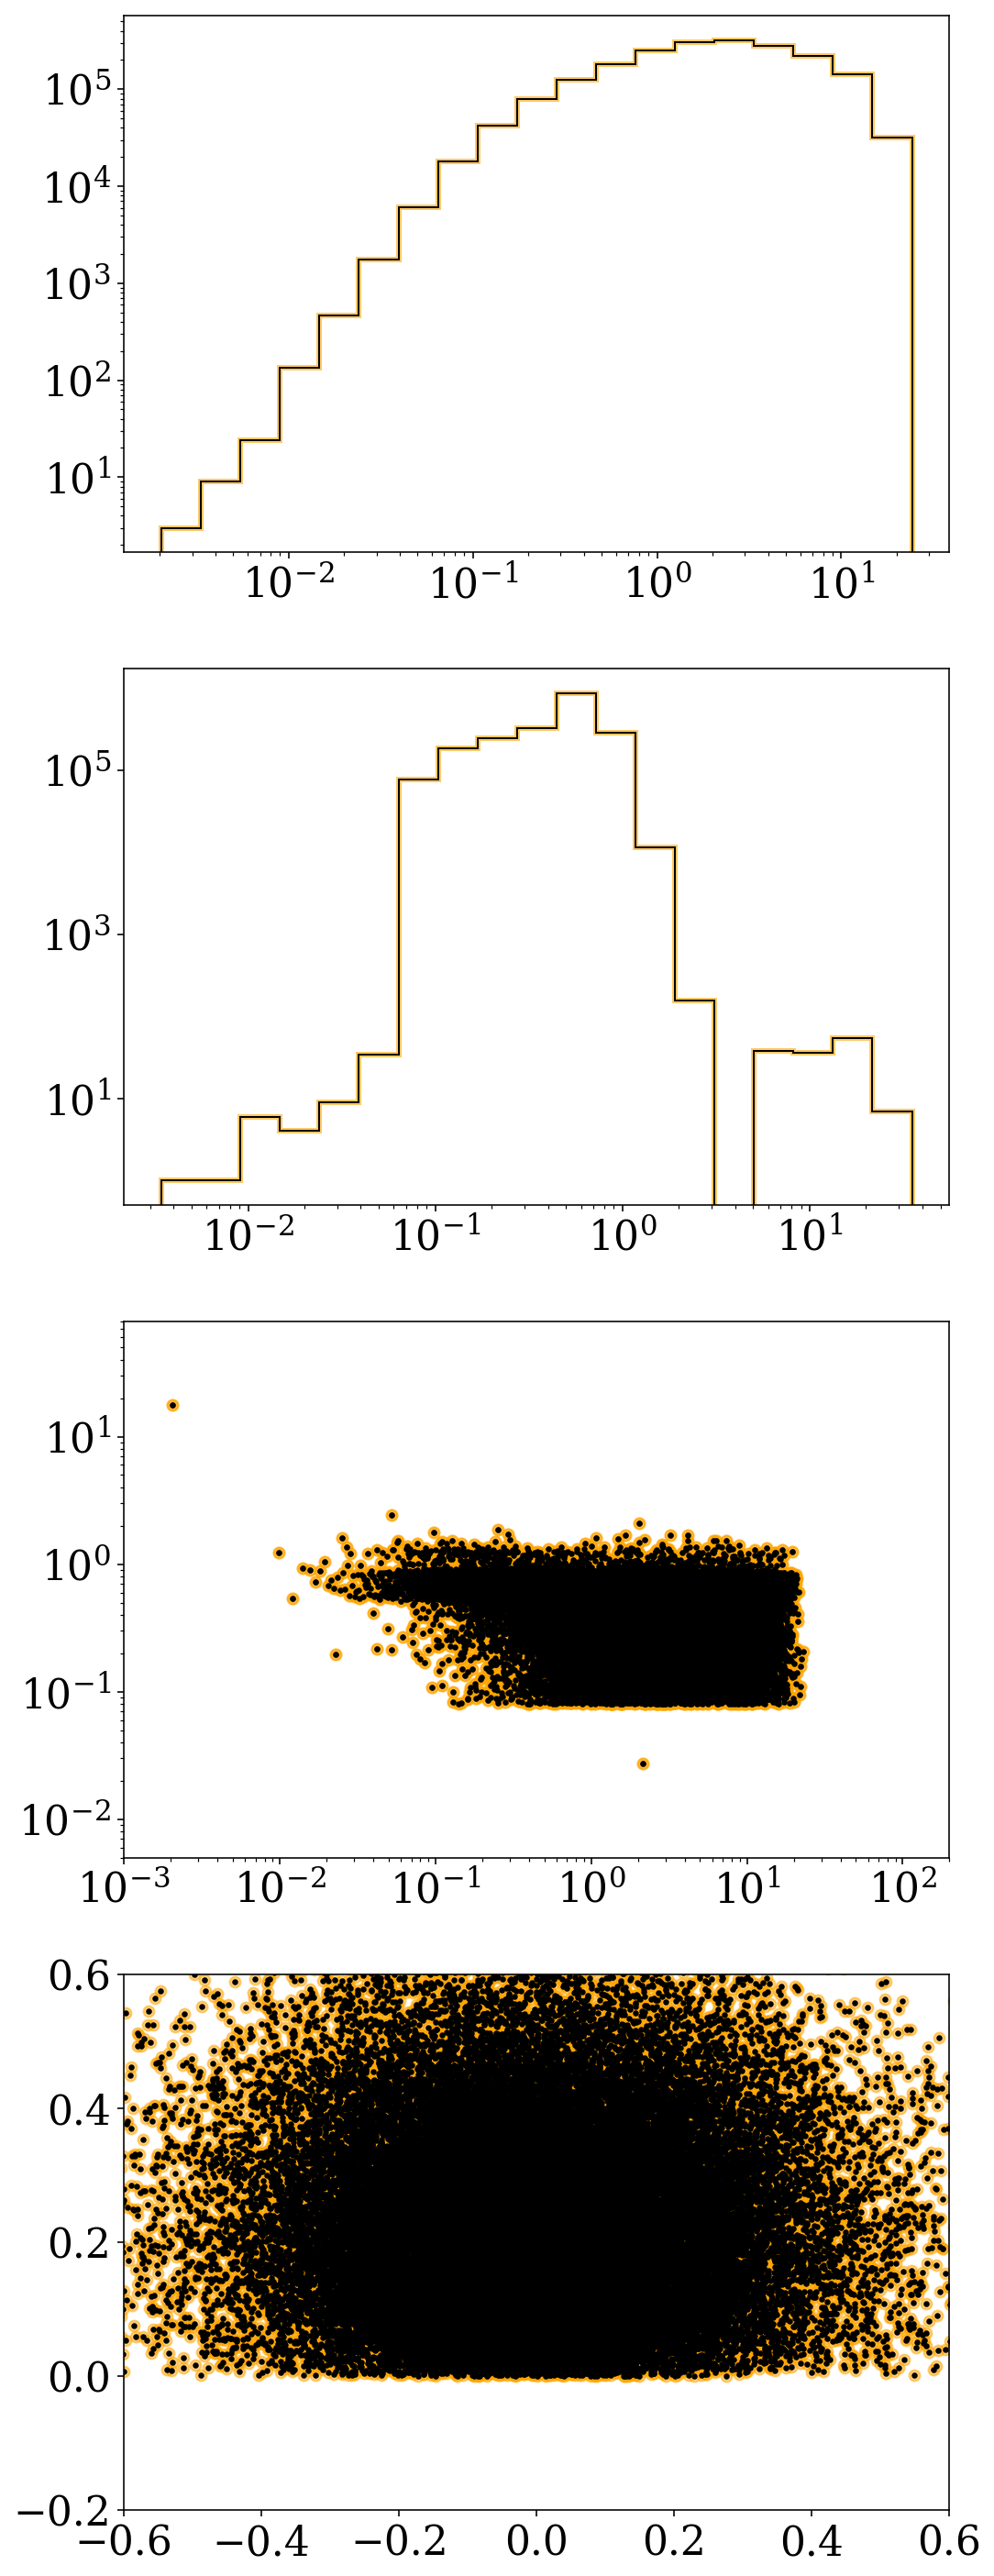

In [14]:
###Comparison
fig, axs = plt.subplots(nrows=4, figsize=(8, 20))
axs[0].hist(r, bins=np.logspace(np.log10(np.min(r)), np.log10(np.max(r)), 20),
            histtype='step', lw=3, alpha=0.6, color='orange')
axs[0].hist(r_res, bins=np.logspace(np.log10(np.min(r_res)), np.log10(np.max(r_res)), 20),
            histtype='step', lw=1, color='k')
axs[0].set_xscale('log')
axs[0].set_yscale('log')

axs[1].hist(mtot, bins=np.logspace(np.log10(np.min(mtot)), np.log10(np.max(mtot)), 20),
            histtype='step', lw=3, alpha=0.6, color='orange')
axs[1].hist(mtot_res, bins=np.logspace(np.log10(np.min(mtot_res)), np.log10(np.max(mtot_res)), 20),
            histtype='step', lw=1, color='k')
axs[1].set_yscale('log')
axs[1].set_xscale('log')

axs[2].scatter(r[::50], mtot[::50], alpha=0.5, color='orange', rasterized=False)
axs[2].scatter(r_res[::50], mtot_res[::50], color='k', s=5, rasterized=False)
axs[2].set_xscale('log')
axs[2].set_yscale('log')
axs[2].set_xlim(xmin=0.001, xmax=200)
axs[2].set_ylim(ymin = 0.005, ymax = 80)

axs[2].scatter(r[::50], mtot[::50], alpha=0.5, color='orange', rasterized=False)
axs[2].scatter(r_res[::50], mtot_res[::50], color='k', s=5, rasterized=False)
axs[2].set_xscale('log')
axs[2].set_yscale('log')
axs[2].set_xlim(xmin=0.001, xmax=200)
axs[2].set_ylim(ymin = 0.005, ymax = 80)

axs[3].scatter(vr[::30], vt[::30], alpha=0.5, color='orange', rasterized=False)
axs[3].scatter(vr_res[::30], vt_res[::30], color='k', s=5, rasterized=False)
#axs[3].set_xscale('symlog')
#axs[3].set_yscale('symlog')
axs[3].set_xlim(xmin=-0.6, xmax=0.6)
axs[3].set_ylim(ymin = -0.2, ymax = 0.6)

fig.tight_layout()

print(np.array_equal(r,r_res))
print(np.array_equal(mtot,mtot_res))
print(np.array_equal(vr,vr_res))
print(np.array_equal(vt, vt_res))
print(np.allclose(vr,vr_res))
print(np.allclose(vt, vt_res))

#print(np.where(vr!=vr_res))
#print(np.where(vt!=vt_res))

#print(vt[1300], vr[4])

True
False
True
True
True
True
True
True
False
True
True
True
True
True


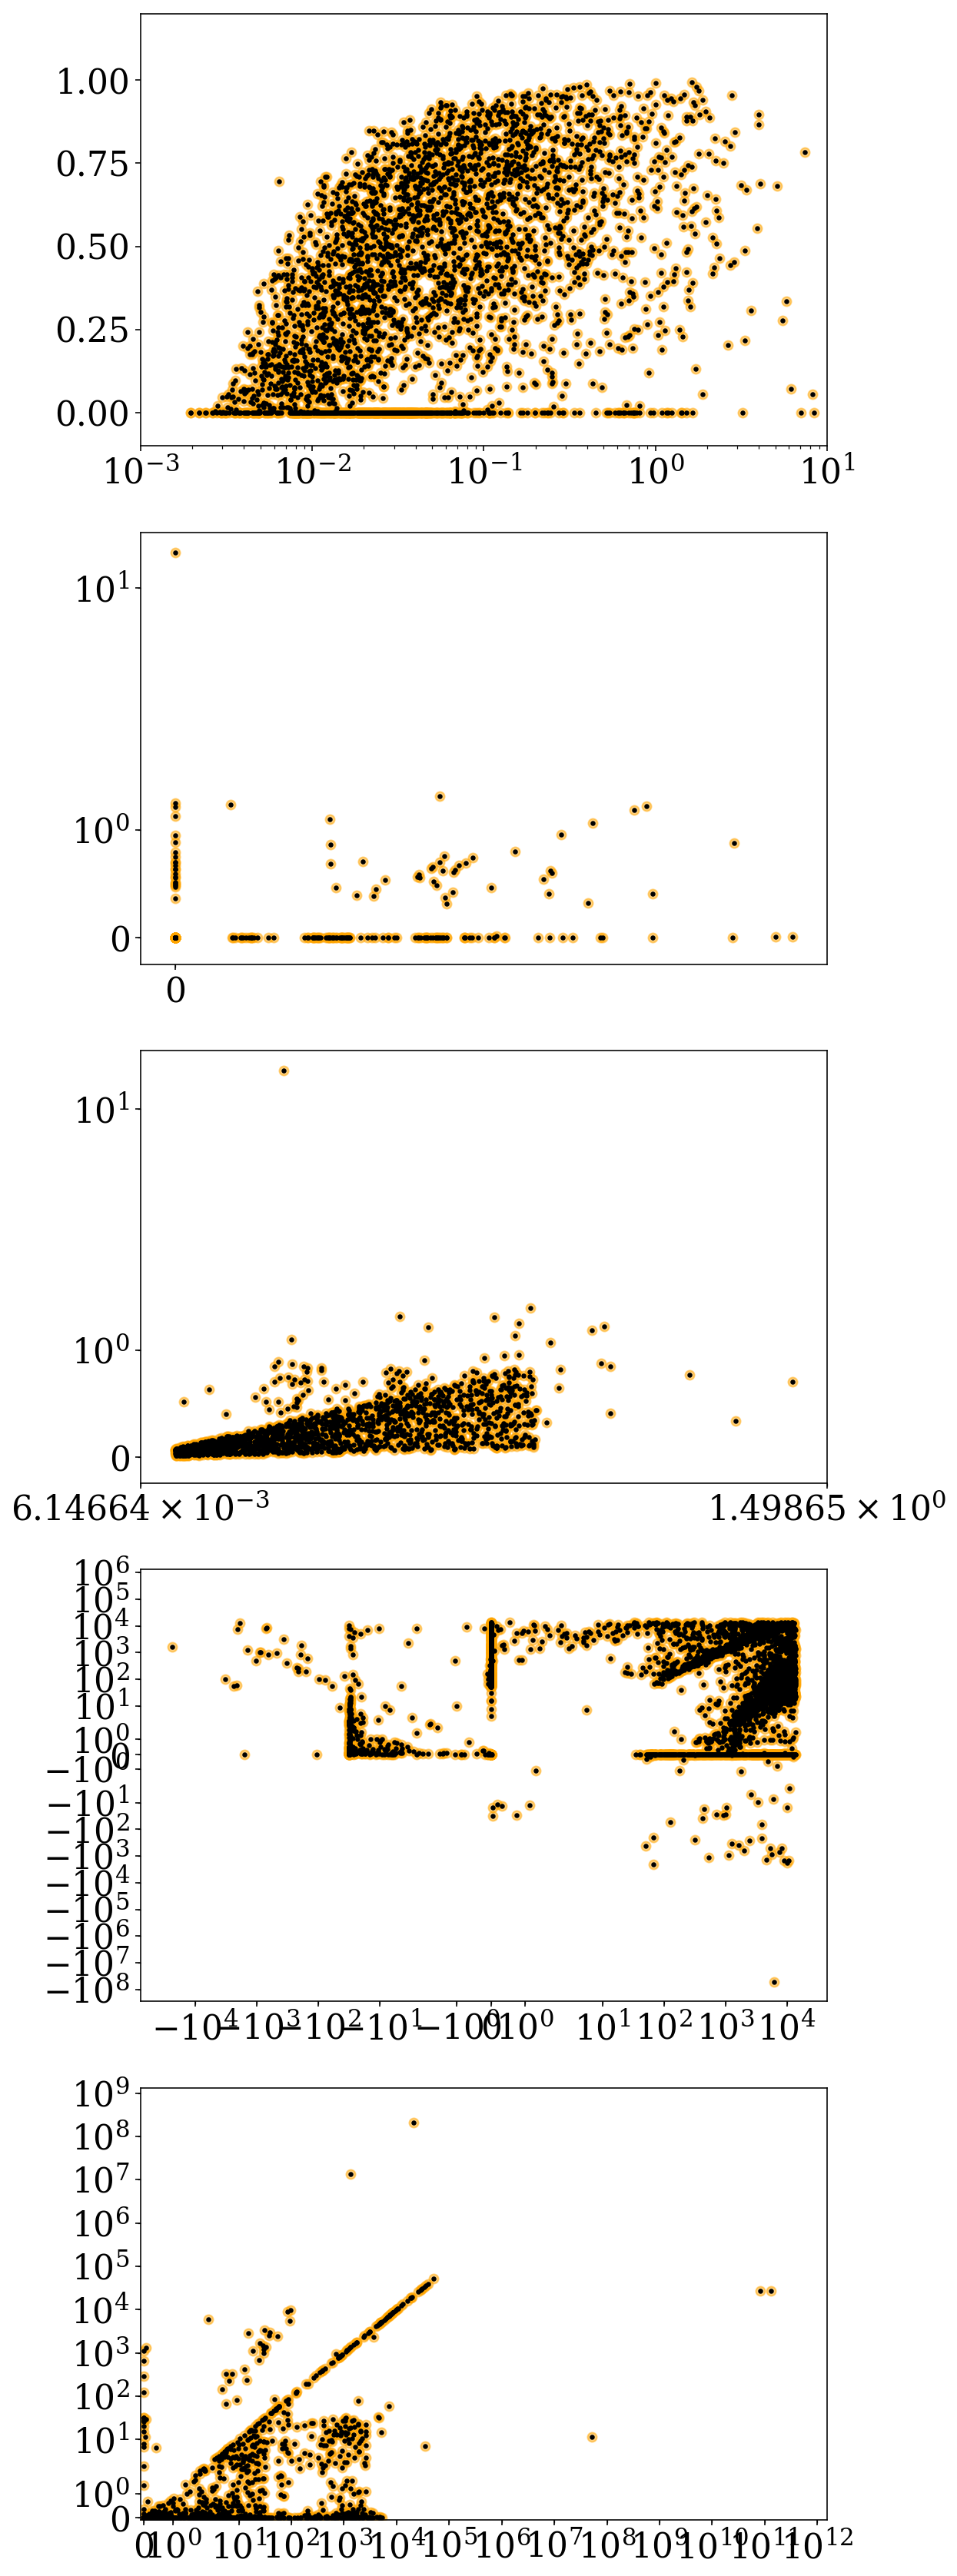

In [15]:
##Comparison binaries
fig, axs = plt.subplots(nrows=5, figsize=(8, 30))
axs[0].scatter(sma[binflag==1][::10], ecc[binflag==1][::10], alpha=0.5, color='orange', rasterized=False)
axs[0].scatter(sma_res[binflag_res==1][::10], ecc_res[binflag_res==1][::10], color='k', s=5, rasterized=False)
axs[0].set_xscale('log')
#axs.set_yscale('log')
axs[0].set_xlim(xmin=0.001, xmax=10)
axs[0].set_ylim(ymin=-0.1, ymax = 1.2)

axs[1].scatter(mc0[binflag==1][::20], mc1[binflag==1][::20], alpha=0.5, color='orange', rasterized=False)
axs[1].scatter(mc0_res[binflag_res==1][::20], mc1_res[binflag_res==1][::20], color='k', s=5, rasterized=False)
axs[1].set_xscale('symlog')
axs[1].set_yscale('symlog')

axs[2].scatter(m00[binflag==1][::20], m01[binflag==1][::20], alpha=0.5, color='orange', rasterized=False)
axs[2].scatter(m00_res[binflag_res==1][::20], m01_res[binflag_res==1][::20], color='k', s=5, rasterized=False)
axs[2].set_xscale('symlog')
axs[2].set_yscale('symlog')

axs[3].scatter(epoch0[binflag==1], epoch1[binflag==1], alpha=0.5, color='orange', rasterized=False)
axs[3].scatter(epoch0_res[binflag_res==1], epoch1_res[binflag_res==1], color='k', s=5, rasterized=False)
axs[3].set_xscale('symlog')
axs[3].set_yscale('symlog')

axs[4].scatter(ospin0[binflag==1][::20], ospin1[binflag==1][::20], 
               alpha=0.5, color='orange', rasterized=False)
axs[4].scatter(ospin0_res[binflag_res==1][::20], ospin1_res[binflag_res==1][::20], 
               color='k', s=5, rasterized=False)
axs[4].set_xscale('symlog')
axs[4].set_yscale('symlog')
axs[4].set_xlim(xmin=-0.1)
axs[4].set_ylim(ymin=-0.1)

print(np.array_equal(sma,sma_res))
print(np.array_equal(ecc,ecc_res))
print(np.array_equal(mc0[binflag==1], mc0_res[binflag==1]))
print(np.array_equal(mc1[binflag==1], mc1_res[binflag==1]))
print(np.array_equal(m00[binflag==1], m00_res[binflag==1]))
print(np.array_equal(m01[binflag==1], m01_res[binflag==1]))
print(np.array_equal(k0[binflag==1], k0_res[binflag_res==1]))
print(np.array_equal(k1[binflag==1], k1_res[binflag_res==1]))
print(np.array_equal([1,2,3,4], [4,3,2,1]))
print(np.allclose(ecc,ecc_res))
print(np.allclose(mc0[binflag==1], mc0_res[binflag==1]))
print(np.allclose(mc1[binflag==1], mc1_res[binflag==1]))
print(np.allclose(m00[binflag==1], m00_res[binflag==1]))
print(np.allclose(m01[binflag==1], m01_res[binflag==1]))

#print(np.where(r!=r_res))
#print(r[0], r_res[0])

#print(sma[binflag==1][1000])
#print(ecc[binflag==1][1000])
#print(mc0[binflag==1][10000])
#print(m00[binflag==1][1000])
#print(epoch0[binflag==1][504])

In [16]:
##Convert 1D to 3D
def convert_to_3d(r, vr, vt, SEEDY=10):
    #np.random.seed(SEEDY)
    random.seed(SEEDY)
    #costheta = np.random.uniform(-1, 1)
    #sintheta = (1-costheta**2.)**0.5

    if np.shape(r)==():
        #print 'came here'
        sintheta = np.random.uniform(low=-1., high=1.)
        phi = np.random.uniform(low=0., high=2.*np.pi)
        anglev = np.random.uniform(low=0., high=2.*np.pi)
    else:
        #print 'came here too'
        r = np.array(r)
        vr = np.array(vr)
        vt = np.array(vt)
    
        sintheta = np.random.uniform(low=-1., high=1., size=len(r))
        phi = np.random.uniform(low=0., high=2.*np.pi, size=len(r))
        anglev = np.random.uniform(low=0., high=2.*np.pi, size=len(r))

    print(sintheta, phi, anglev)
        
    costheta = (1-sintheta**2.)**0.5
    #costheta = (1-sintheta**2.)**0.5
    #phi = np.random.uniform(low=0., high=2.*np.pi, size=len(r))
    
    rz = r*sintheta
    rx = r*costheta*np.cos(phi)
    ry = r*costheta*np.sin(phi)
    
    #anglev = np.random.uniform(low=0., high=2.*np.pi, size=len(r))
    magv = (vr*vr + vt*vt)**0.5 
    thetadot = np.cos(anglev) * vt/r
    phidot = np.sin(anglev)*vt/(r*costheta)
    
    #vx = vr * np.sin(np.arccos(costheta)) * np.cos(phi) + r * thetadot * costheta * np.cos(phi) - r * phidot * np.sin(np.arccos(costheta)) * np.sin(phi)
    vx = vr * costheta * np.cos(phi) - r * phidot * costheta * np.sin(phi) - r * thetadot * sintheta * np.cos(phi)
    #vy = vr * np.sin(np.arccos(costheta)) * np.sin(phi) + r * thetadot * costheta * np.sin(phi) + r * phidot * np.sin(np.arccos(costheta)) * np.cos(phi)
    vy = vr * costheta * np.sin(phi) + r * phidot * costheta * np.cos(phi) - r * thetadot * sintheta * np.sin(phi)
    #vz = vr * costheta - r * thetadot * np.sin(np.arccos(costheta))
    vz = vr * sintheta + r * thetadot * costheta


    r3d = np.array([rx, ry, rz])
    v3d = np.array([vx, vy, vz])

    return r3d, v3d

In [ ]:
###Writing to Nbody file###
res_path = '/projects/b1095/syr904/cmc/CMC-COSMIC/wdmerger_update/CMC-COSMIC/CMC/47_load_bin/'
resouts = glob(res_path+'resoutput*.out')
print(len(resouts))

f2 = open('/projects/b1095/syr904/cmc/CMC-COSMIC/wdmerger_update/CMC-COSMIC/CMC/47_load_bin/file2.dat', 'w+')
f2.write('#1.M1 2.KW 3.M0 4.EPOCH1 5.OSPIN 6.MC\n')

for xx in range(len(resouts)):
    restart_file = res_path+'resoutput_'+str(xx)+'.out'
    nline.append(0)
    with open(restart_file, 'r') as fres:
        next(fres)
        for line in fres:
            nline[xx]+=1
            data = line.split()
            
            binflag_res.append(int(data[2]))
            r_res.append(float(data[3]))
            mtot_res.append(float(data[6]))
            vr_res.append(float(data[4])); vt_res.append(float(data[5]))
            
            id0_res.append(float(data[9]))
            sma_res.append(float(data[15])); ecc_res.append(float(data[16]))
            k0_res.append(int(data[19])); k1_res.append(int(data[20]))
            ospin0_res.append(float(data[21])); ospin1_res.append(float(data[22]))
            epoch0_res.append(float(data[23])); epoch1_res.append(float(data[24]))
            mc0_res.append(float(data[26])); mc1_res.append(float(data[27]))
            m00_res.append(float(data[13])); m01_res.append(float(data[14]))
            